# Readme

This notebook contains the model for our machine learning damage classification task. 

The image that will be used for training is a polygon image that has been extracted from a complete satellite image. 

What will this notebook do:
- Generate a csv file with polygon ID and it's corresponding damage labels. We use this csv later to input data into the model using `flow_from_dataframe`. 
- Apply multiple augmentations to our training data for all polygon images such as ; horizontal flip, vertical flip, rotation, width and height shift. 
- Resize our input images to 128x128, this number is not too small to cause loss of necessary information, but not too large to cause our CNN performance slowed down.
- Apply undersampling technique to change the composition of the training dataset because the number of buildings that has no damage and the number of destroyed buildings are imbalance.
- Create a Keras Model with the Sequential linear stack of layers. All Convolutional blocks will use ReLU for the activation parameter, We call Flatten method to transform 3 dimensional feature maps into 1 dimensional tensor.
- Training the model
- Plot the accuracy and loss using livelossplot
- Save the model

To run this notebook you need kaggle api file to interact with datasets to download the data. Upload your kaggle API file to '/content' directory and you will be ready to run this notebook.

If you've never used the kaggle API, please follow this instruction:
* Log in to [Kaggle](https://www.kaggle.com/). Create a new account if you don't have one.
* Go to your account settings by clicking on the top right.
* Scroll down to the API section.
* Click on 'Create New API Token' button to download the token as a JSON file.
* Upload it to '/content' directory in your colab environment.

# Load Data

In [ ]:
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'
!kaggle datasets download auliawicaksono/palu-disaster-satellite-images
!ls

import os
import zipfile

with zipfile.ZipFile('/content/palu-disaster-satellite-images.zip', 'r') as zip_ref:
    zip_ref.extractall()

import shutil

if 'full_palu' not in os.listdir('/content'):
  os.mkdir('full_palu')
  os.mkdir('full_palu/images')
  os.mkdir('full_palu/labels')
else:
   shutil.rmtree('/content/full_palu')
   os.mkdir('full_palu')
   os.mkdir('full_palu/images')
   os.mkdir('full_palu/labels')

folder_list = ['hold', 'test', 'train']
subfolder_list = ['/images', '/labels']
img_dest_dir = '/content/full_palu/images'
json_dest_dir = '/content/full_palu/labels' 

for folder in folder_list:
  for files in os.listdir('/content/palu/' + folder +  subfolder_list[0]):
    shutil.copy('/content/palu/' + folder + subfolder_list[0] + '/' + files, img_dest_dir)

for folder in folder_list:
  for files in os.listdir('/content/palu/' + folder +  subfolder_list[1]):
    shutil.copy('/content/palu/' + folder + subfolder_list[1] + '/' + files, json_dest_dir)

os.mkdir('/content/xBD')
shutil.move('/content/full_palu', '/content/xBD')

Done
 99% 577M/584M [00:16<00:00, 46.8MB/s]
100% 584M/584M [00:16<00:00, 37.5MB/s]
palu-disaster-satellite-images.zip  sample_data


'/content/xBD/full_palu'

In [ ]:
from collections import defaultdict

damage_intensity_encoding = defaultdict(lambda:0)
damage_intensity_encoding['no-damage'] = 0
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding

defaultdict(<function __main__.<lambda>>,
            {'destroyed': 3,
             'major-damage': 2,
             'minor-damage': 1,
             'no-damage': 0})

In [ ]:
from PIL import Image
import numpy as np
import json
from tqdm import tqdm
import shapely
import shapely.wkt
import cv2

disaster_paths = '/content/xBD/full_palu/images'
image_paths = []
image_paths.extend(disaster_paths + '/' + image for image in os.listdir(disaster_paths))

x_data = []
y_data = []

processed_img_path = '/content/xBD/full_palu/processed_img'

if 'processed_img' not in os.listdir('/content/xBD/full_palu'):
  os.mkdir(processed_img_path)
else:
   shutil.rmtree(processed_img_path)
   os.mkdir(processed_img_path)

for img_path in tqdm(image_paths):

    img_obj = Image.open(img_path)
    img_array = np.array(img_obj)
    height, width, color = img_array.shape

    label_path = img_path.replace('images', 'labels').replace('png', 'json')
    label_file = open(label_path)
    label_data = json.load(label_file)

    for feat in label_data['features']['xy']:
        try:
            damage_type = feat['properties']['subtype']
        except: 
            damage_type = 'no-damage'
            continue
        y_data.append(damage_intensity_encoding[damage_type])

        polygon_geom = shapely.wkt.loads(feat['wkt'])
        polygon_pts = np.array(list(polygon_geom.exterior.coords))

        xcoords = polygon_pts[:, 0]
        ycoords = polygon_pts[:, 1]

        xmin = np.min(xcoords)
        xmax = np.max(xcoords)
        ymin = np.min(ycoords)
        ymax = np.max(ycoords)

        xdiff = xmax - xmin
        ydiff = ymax - ymin

        xmin = max(int(xmin - (xdiff * 0.75)), 0)
        xmax = min(int(xmax + (xdiff * 0.75)), width)
        ymin = max(int(ymin - (ydiff * 0.75)), 0)
        ymax = min(int(ymax + (ydiff * 0.75)), height)

        poly_img = img_array[ymin:ymax, xmin:xmax, :]
        
        poly_uuid = feat['properties']['uid'] + '.png'
        cv2.imwrite(processed_img_path + "/" + poly_uuid, poly_img)
        x_data.append(poly_uuid)

100%|██████████| 392/392 [00:50<00:00,  7.74it/s]


In [ ]:
import pandas as pd

df_full = pd.DataFrame({'uuid':x_data, 'labels':y_data})
df_full['labels'].value_counts()

0    47407
3     7203
2     1178
1        1
Name: labels, dtype: int64

In [ ]:
df_full['labels'].replace({2: 1}, inplace=True)
df_full['labels'].replace({3: 1}, inplace=True)

In [ ]:
df_full['labels'].value_counts()

0    47407
1     8382
Name: labels, dtype: int64

##### Undersampling

In [ ]:
classes_zero = df_full[df_full['labels'] == 0]
classes_one = df_full[df_full['labels'] == 1]

print(f'Class 0: {len(classes_zero)}')
print(f'Class 1: {len(classes_one)}')

classes_zero = classes_zero.sample(len(classes_one))

print(f'Class 0: {len(classes_zero)}')
print(f'Class 1: {len(classes_one)}')

Class 0: 47407
Class 1: 8382
Class 0: 8382
Class 1: 8382


In [ ]:
df_full = pd.concat([classes_one, classes_zero])
df_full.sample(frac=1).reset_index(drop=True)

,uuid,labels
0,b558250d-9343-490d-8e95-a3d6b1a490d1.png,0
1,78c12626-e718-4d2f-b3b2-4c166eae225d.png,0
2,310ffc58-4e53-47c2-ac4c-aaf0f94d25f1.png,1
3,8bdea151-2e9f-4009-9793-88e0c88388f9.png,0
4,84e22563-a96d-4430-8cc6-d5b3b4cf154a.png,1
...,...,...
16759,a5df6870-129d-436a-836f-b7f460812208.png,1
16760,54656262-4329-401b-8a20-bee1b2279ec7.png,0
16761,c055e886-2f96-4f64-a5e7-71ffdbbecff0.png,0
16762,1b034b2b-f130-41fc-ad56-b24e8158e2b5.png,0


In [ ]:
x_data = df_full['uuid'].tolist()
y_data = df_full['labels'].tolist()

In [ ]:
random_state = 123

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = random_state)

df_train = pd.DataFrame({'uuid':x_train, 'labels':y_train})
df_test = pd.DataFrame({'uuid':x_test, 'labels':y_test})

In [ ]:
test_path = '/content/xBD/full_palu/processed_img/test'
train_path = '/content/xBD/full_palu/processed_img/train'

if 'test' and 'train' not in os.listdir('/content/xBD/full_palu/processed_img'):
  os.mkdir(test_path)
  os.mkdir(train_path)
else:
  shutil.rmtree(train_path)
  shutil.rmtree(test_path)
  os.mkdir(test_path)
  os.mkdir(train_path)

for png in df_train['uuid']:
  shutil.move('/content/xBD/full_palu/processed_img/' + png, train_path)

for png in df_test['uuid']:
  shutil.move('/content/xBD/full_palu/processed_img/' + png, test_path)

 # Model

##### Generator

In [ ]:
import keras.preprocessing

train_path = '/content/xBD/full_palu/processed_img/train'
df_train['labels'] = df_train['labels'].apply(str)

RANDOM_SEED = 123
BATCH = 64

gen = keras.preprocessing.image.ImageDataGenerator(
                          horizontal_flip=True,
                          vertical_flip=True,
                          rotation_range=90,
                          width_shift_range=0.1,
                          height_shift_range=0.1,
                          rescale=1/255.)

train_gen_flow = gen.flow_from_dataframe(dataframe = df_train,
                        directory = train_path,
                        x_col = 'uuid',
                        y_col = 'labels',
                        batch_size = BATCH,
                        seed = RANDOM_SEED,
                        class_mode = "categorical",
                        target_size = (128, 128))

Found 13411 validated image filenames belonging to 2 classes.


In [ ]:
df_test['labels'] = df_test['labels'].apply(str)

gen = keras.preprocessing.image.ImageDataGenerator(
                          rescale=1/255.)


validation_gen = gen.flow_from_dataframe(dataframe = df_test,
                                directory = test_path,
                                x_col = 'uuid',
                                y_col = 'labels',
                                batch_size = BATCH,
                                shuffle = False,
                                seed = RANDOM_SEED,
                                class_mode="categorical",
                                target_size=(128, 128))

Found 3353 validated image filenames belonging to 2 classes.


##### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

model = Sequential([
                    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 128, 3)),

                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),

                    Conv2D(64, (3,3), padding='same', activation='relu'),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D((2,2)),

                    Conv2D(128, (3,3), padding='same', activation='relu'),
                    Conv2D(128, (3,3), activation='relu'),
                    Activation('relu'),
                    MaxPooling2D((2,2)),

                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       7

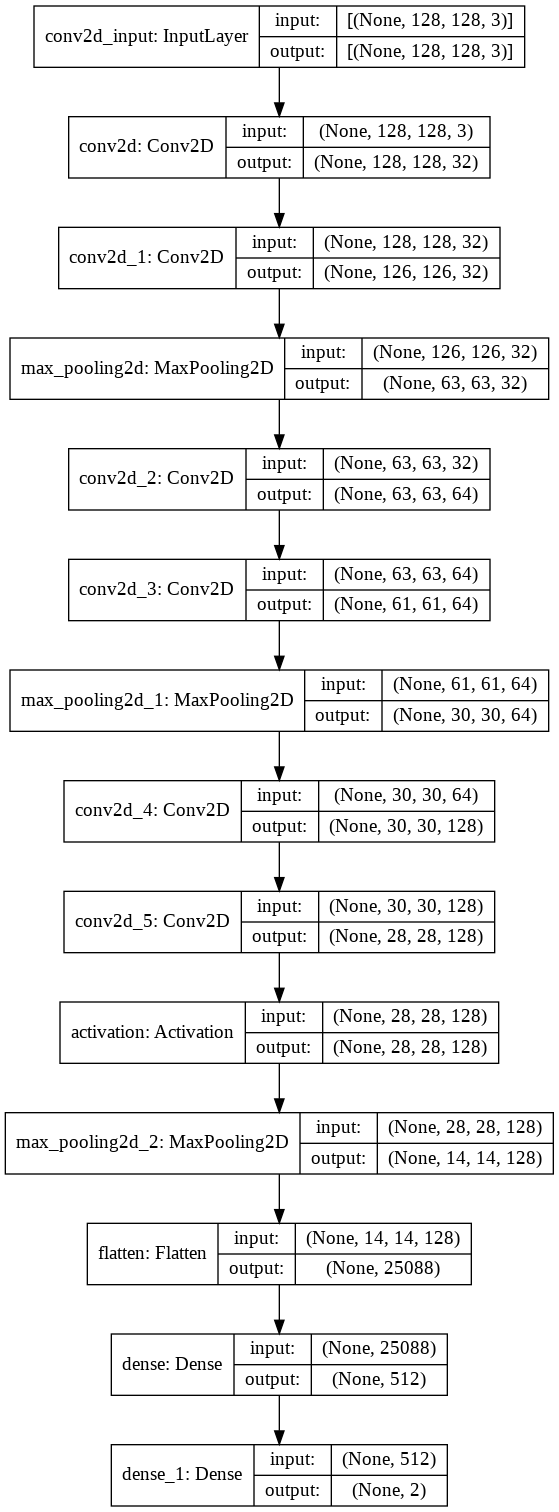

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
pip install livelossplot

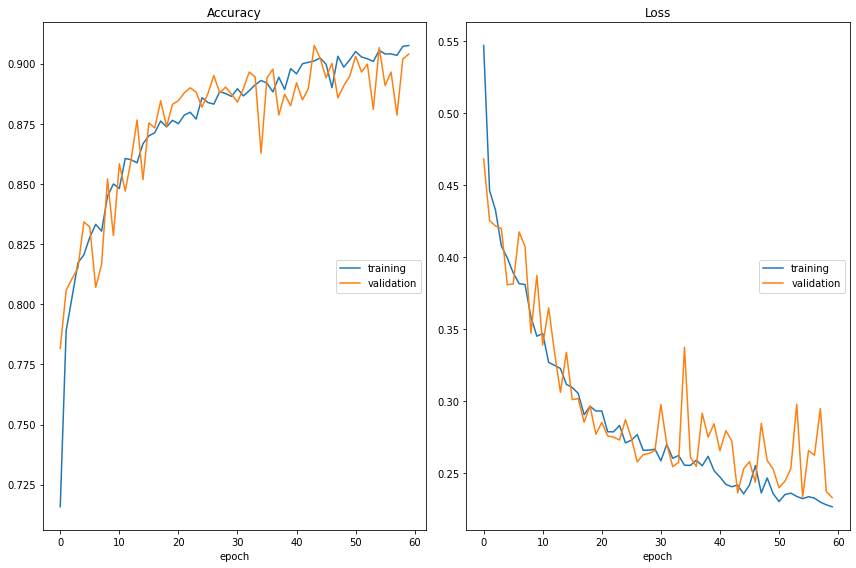

Accuracy
	training         	 (min:    0.716, max:    0.908, cur:    0.908)
	validation       	 (min:    0.782, max:    0.908, cur:    0.904)
Loss
	training         	 (min:    0.226, max:    0.547, cur:    0.226)
	validation       	 (min:    0.233, max:    0.468, cur:    0.233)


In [ ]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras

EPOCHS = 60

model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['acc'])

checkpoint = ModelCheckpoint(filepath='model.hdf5', 
                               verbose=1, 
                               save_best_only=True)

fit_history = model.fit_generator(
    train_gen_flow,
    steps_per_epoch = len(train_gen_flow),
    epochs = EPOCHS,
    validation_data = validation_gen,
    validation_steps = len(validation_gen),
    callbacks=[checkpoint, PlotLossesKeras()]
)

In [ ]:
model.save('Building Damage Detection Model.hdf5')